### Machine-to-Machine (M2M) API:

---

#### Pros:

1. **Same for Manual Download**: The same API we used for downloading data manually can be used for automating the process.

2. **Easy to Use**: The API is easy to use and doesn't require any special setup. Only USGS account and password are required.

---

#### Cons:

1. **Learning Curve**: Need to get familiar with the API and its parameters. e.g. how to find the metal text and the corresponding band files.

2. **Little Technical Support**: The API is not well documented and there is little technical support. Website: "This service is provided "as is" without guarantee of technical assistance."
---

#### How-to:

**Run block by block and remember to change login data"**

In [1]:
import requests
import json
import pandas as pd

In [2]:
def post_request(endpoint, data, auth_token = None):
    login_url = 'https://m2m.cr.usgs.gov/api/api/json/stable/' + endpoint
    headers = {
        'X-Auth-Token': auth_token
    }
    response = requests.post(login_url, json=data, headers=headers)
    if response.status_code != 200:
        print("Error: " + str(response.status_code))
        return None
    response = response.json()
    response = json.dumps(response, indent=4)
    return response

In [3]:

login_data = {
    "username": "tongjin",
    "password": "Link9jintong"
}

# Login
api_key = json.loads(post_request("login", login_data))['data']

if api_key:
    # Perform actions with the obtained API key
    print("Login successful. API Key:", api_key)


Login successful. API Key: eyJjaWQiOjI2OTQxNDg3LCJzIjoiMTcwMDAxOTUwNSIsInIiOjU1MiwicCI6WyJ1c2VyIiwiZG93bmxvYWQiLCJvcmRlciJdfQ==


In [4]:
dataset_id = "5e81f14f59432a27"
dataset_name = "landsat_ot_c2_l1"
dataset_search_response = post_request("dataset",{"datasetName":dataset_name},api_key)
print(dataset_search_response)

{
    "requestId": 1518551940,
    "version": "stable",
    "sessionId": 252796049,
    "data": {
        "abstractText": "The USGS Earth Resources Observation and Science (EROS) Center archive holds data collected by the Landsat suite of satellites, beginning with Landsat 1 in 1972.  Landsat 8, launched February 11, 2013, is the latest Landsat sensor.",
        "acquisitionStart": "2013-04-11",
        "acquisitionEnd": null,
        "catalogs": [
            "EE",
            "GV"
        ],
        "collectionName": "Landsat 8-9 OLI/TIRS C2 L1",
        "collectionLongName": "Landsat 8-9 Operational Land Imager and Thermal Infrared Sensor Collection 2 Level-1",
        "datasetId": "5e81f14f59432a27",
        "datasetAlias": "landsat_ot_c2_l1",
        "datasetCategoryName": "Landsat Collection 2 Level-1",
        "dataOwner": "LSAA",
        "dateUpdated": "2023-10-17 12:38:49.315571-05",
        "doiNumber": "https://doi.org//10.5066/P975CC9B",
        "ingestFrequency": "P1D",
  

In [5]:
# read in csv file for the bounding box
coordinates = pd.read_csv("WRS-2_reduced_regions_coordinates\WRS-2_R56_R60_Regions\R56_R60_P6_P10_coordinates.csv")

# read first row of the csv file
coordinates = coordinates.iloc[0]

lower_left_lat = coordinates['LL Lat']
lower_left_lon = coordinates['LL Lon']
upper_right_lat = coordinates['UR Lat']
upper_right_lon = coordinates['UR Lon']

print(lower_left_lat, lower_left_lon, upper_right_lat, upper_right_lon)

-0.685 -81.071 0.685 -79.031


In [6]:
scene_data ={
     "maxResults": 10000,
    "datasetName": dataset_name,
    "sceneFilter": {
        "spatialFilter": {
            "filterType": "mbr",
            "lowerLeft": {
                "latitude": lower_left_lat,
                "longitude":  lower_left_lon
            },
            "upperRight": {
                    "latitude": upper_right_lat,
                    "longitude": upper_right_lon
            }
        },
        "metadataFilter": None,
        "cloudCoverFilter": {
            "max": 10,
            "min": 0,
            "includeUnknown": False
        },
        "acquisitionFilter": {
            "end": "2023-11-06",
            "start": "2022-01-01"
        }
    },
    "metadataType": "summary",
}

scene_search_response = post_request("scene-search",scene_data,api_key)
print(scene_search_response)

{
    "requestId": 1518552242,
    "version": "stable",
    "sessionId": 252796049,
    "data": {
        "results": [
            {
                "browse": [
                    {
                        "id": "5e81f7d39594374",
                        "browseRotationEnabled": null,
                        "browseName": "Reflective Browse",
                        "browsePath": "https://landsatlook.usgs.gov/gen-browse?size=rrb&type=refl&product_id=LC09_L1TP_011059_20230328_20230329_02_T1",
                        "overlayPath": "https://landsatlook.usgs.gov/dynamic-tiler/scenes/LC09_L1TP_011059_20230328_20230329_02_T1/tiles/{z}/{x}/{y}.png?layer=natural_color",
                        "overlayType": "ls_chs",
                        "thumbnailPath": "https://landsatlook.usgs.gov/gen-browse?size=thumb&type=refl&product_id=LC09_L1TP_011059_20230328_20230329_02_T1"
                    },
                    {
                        "id": "5e82332d4223a26c",
                        "br

In [7]:
print("The length of the result is "+ str(json.loads(scene_search_response)['data']['recordsReturned']))

The length of the result is 3


In [10]:
results_list = json.loads(scene_search_response)['data']['results']
top_resutls_list = {}
results_list_len = min(5,len(results_list))
for i in range(results_list_len):
    data_entity_id = results_list[i]['entityId']
    download_options = post_request("download-options",{"datasetName":dataset_name,"entityIds":[data_entity_id]},api_key)
    download_options = json.loads(download_options)
    top_resutls_list[data_entity_id] = []
    for image_i in download_options['data'][0]["secondaryDownloads"]:
        if image_i['entityId'].endswith('B2_TIF') or image_i['entityId'].endswith('B3_TIF') or image_i['entityId'].endswith('B4_TIF') or image_i['entityId'].endswith('MTL_TXT'):
            top_resutls_list[data_entity_id].append({
                "entityId": image_i['entityId'],
                "productId":image_i['id']
            })
    if len(top_resutls_list[data_entity_id]) != 4:
        print("Error: the length of the top_resutls_list[data_entity_id] is not 4")

# download_options['data'] will return several download sources, we just pick the first one as [0]


print(top_resutls_list)

{'LC90110592023087LGN00': [{'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B2_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B3_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_B4_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1TP_011059_20230328_20230329_02_T1_MTL_TXT', 'productId': '5e8206bf6bc4a163'}], 'LC90110592022116LGN01': [{'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B2_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B3_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_B4_TIF', 'productId': '5e8206bf6bc4a163'}, {'entityId': 'L1_LC09_L1GT_011059_20220426_20230418_02_T2_MTL_TXT', 'productId': '5e8206bf6bc4a163'}], 'LC90100612022061LGN01': [{'entityId': 'L1_LC09_L1GT_010061_20220302_20230426_02_T2_B2_TIF', 'productId': '5e8206bf6bc4a163'}, {'entity

In [12]:
# use the first one as an example
download_args ={"downloads":top_resutls_list['LC90110592023087LGN00']}

# download_args = {
#     "downloads": [
#         {
#             "entityId": "L1_LC09_L1TP_015027_20231018_20231018_02_T1_B10_TIF",
#             "productId": "5f85f0419985f2aa",
#         }
#     ],
# }

download = post_request("download-request",download_args,api_key)
print(download)

{
    "requestId": 1518552793,
    "version": "stable",
    "sessionId": 252796049,
    "data": {
        "availableDownloads": [
            {
                "downloadId": 499467469,
                "eulaCode": null,
                "url": "https://landsatlook.usgs.gov/data/collection02/level-1/standard/oli-tirs/2023/011/059/LC09_L1TP_011059_20230328_20230329_02_T1/LC09_L1TP_011059_20230328_20230329_02_T1_B2.TIF?requestSignature=eyJjb250YWN0SWQiOjI2OTQxNDg3LCJkb3dubG9hZElkIjo0OTk0Njc0NjksImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTExLTE0VDIxOjM5OjU4LTA2OjAwIiwiaWQiOiJMQzA5X0wxVFBfMDExMDU5XzIwMjMwMzI4XzIwMjMwMzI5XzAyX1QxX0IyLlRJRiIsInNpZ25hdHVyZSI6IiQ1JCRJVVp2bHBuV0RmYU5ZTW5vVmRmN1cuc0E0YkJ6WGF6c2pVcmtpcjBMdE83In0="
            },
            {
                "downloadId": 499467470,
                "eulaCode": null,
                "url": "https://landsatlook.usgs.gov/data/collection02/level-1/standard/oli-tirs/2023/011/059/LC09_L1TP_011059_20230328_20230329_02_T1/LC09_L1TP_011059_20230328_202303

In [15]:
# Parse the JSON data
download_data = json.loads(download)

# Extract the download URL for the first file
download_url = download_data['data']['availableDownloads'][0]['url']

# Save the file to your laptop
response = requests.get(download_url)
if response.status_code == 200:
    with open('test.TIF', 'wb') as file:
        file.write(response.content)
    print("File saved to 'test.TIF'")
else:
    print("Failed to download the file.")

File saved to 'test.TIF'


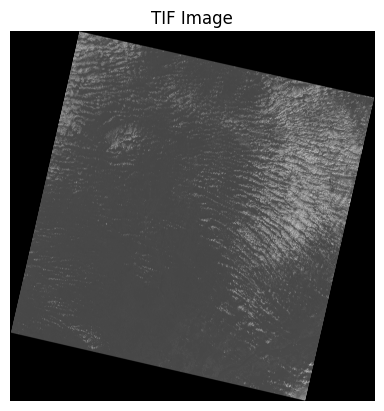

In [17]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Assuming you have saved the .tif file as 'downloaded_file.tif'
image_path = 'test.tif'

# Load and display the image
image = imread(image_path)
plt.imshow(image, cmap='gray')  # 'cmap' specifies the color map, you can change it as needed
plt.axis('off')  # Turn off axis labels
plt.title('TIF Image')
plt.show()


# Other not used API Calls:

In [ ]:
dataset_download_options_args ={
    "datasetName": dataset_name,
    "sceneFilter": {
        "spatialFilter": {
            "filterType": "mbr",
            "lowerLeft": {
                "latitude": 40,
                "longitude":  -79
            },
            "upperRight": {
                    "latitude": 50,
                    "longitude": -80
            }
        },
        "metadataFilter": None,
        "cloudCoverFilter": {
            "max": 100,
            "min": 0,
            "includeUnknown": True
        },
    },
}
dataset_download_options = post_request("dataset-download-options",dataset_download_options_args,api_key)
print(dataset_download_options)